In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm

[Data Scorce](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia)

In [3]:
import matplotlib.pyplot as plt 
import torch.nn.functional as F 
import torch 
import numpy as np 

def show_image(image,label,get_denormalize = True):
    
    image = image.permute(1,2,0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])
    
    if get_denormalize == True:
        image = image*std + mean
        image = np.clip(image,0,1)
        plt.imshow(image)
        plt.title(label)
        
    else: 
        plt.imshow(image)
        plt.title(label)

def show_grid(image,title = None):
    
    image = image.permute(1,2,0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])
    
    image = image*std + mean
    image = np.clip(image,0,1)
    
    plt.figure(figsize=[15, 15])
    plt.imshow(image)
    if title != None:
        plt.title(title)


def accuracy(y_pred,y_true):
    y_pred = F.softmax(y_pred,dim = 1)
    top_p,top_class = y_pred.topk(1,dim = 1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))


def view_classify(image,ps,label):
    
    class_name = ['COVID','NORMAL', 'PNEUMONIA']
    classes = np.array(class_name)

    ps = ps.cpu().data.numpy().squeeze()
    
    image = image.permute(1,2,0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])
    
    
    image = image*std + mean
    img = np.clip(image,0,1)
    
    fig, (ax1, ax2) = plt.subplots(figsize=(8,12), ncols=2)
    ax1.imshow(img)
    ax1.set_title('Ground Truth : {}'.format(class_name[label]))
    ax1.axis('off')
    ax2.barh(classes, ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(classes)
    ax2.set_yticklabels(classes)
    ax2.set_title('Predicted Class')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

    return None

In [4]:
class CFG:
    epochs =20                              # No. of epochs for training the model
    lr = 0.001                              # Learning rate
    batch_size = 16                         # Batch Size for Dataset

    model_name = 'tf_efficientnet_b4_ns'    # Model name (we are going to import model from timm)
    img_size = 224                          # Resize all the images to be 224 by 224

  # going to be used for loading dataset
    train_path='/media/brats/DRIVE1/akansh/DeepXrays/Data/raw/Chest XR covid/train/'
    validate_path='/media/brats/DRIVE1/akansh/DeepXrays/Data/raw/Chest XR covid/validation/'
#     test_path='/content/drive/MyDrive/chest_xray/test'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("On which device we are on:{}".format(device))

On which device we are on:cuda


In [5]:
from torchvision import transforms as T,datasets

In [6]:
train_transform = T.Compose([
                             
                             T.Resize(size=(CFG.img_size,CFG.img_size)), # Resizing the image to be 224 by 224
                             T.RandomRotation(degrees=(-20,+20)),T.RandomHorizontalFlip(), #Randomly Rotate Images by +/- 20 degrees, Image argumentation for each epoch
                             T.ToTensor(), #converting the dimension from (height,weight,channel) to (channel,height,weight) convention of PyTorch
                             T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]) # Normalize by 3 means 3 StD's of the image net, 3 channels

])

validate_transform = T.Compose([
                             
                             T.Resize(size=(CFG.img_size,CFG.img_size)), # Resizing the image to be 224 by 224
                             #T.RandomRotation(degrees=(-20,+20)), #NO need for validation
                             T.ToTensor(), #converting the dimension from (height,weight,channel) to (channel,height,weight) convention of PyTorch
                             T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]) # Normalize by 3 means 3 StD's of the image net, 3 channels

])

test_transform = T.Compose([
                             
                             T.Resize(size=(CFG.img_size,CFG.img_size)), # Resizing the image to be 224 by 224
                             #T.RandomRotation(degrees=(-20,+20)), #NO need for validation
                             T.ToTensor(), #converting the dimension from (height,weight,channel) to (channel,height,weight) convention of PyTorch
                             T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]) # Normalize by 3 means 3 StD's of the image net, 3 channels

])

In [7]:
trainset=datasets.ImageFolder(CFG.train_path,transform=train_transform)
print("Trainset Size:  {}".format(len(trainset)))

Trainset Size:  17958


In [8]:
validateset=datasets.ImageFolder(CFG.validate_path,transform=validate_transform)
print("validateset Size:  {}".format(len(validateset)))

validateset Size:  3432


In [9]:
# testset=datasets.ImageFolder(CFG.test_path,transform=test_transform)
# print("testset Size:  {}".format(len(testset)))

{'covid': 0, 'normal': 1, 'pneumonia': 2}


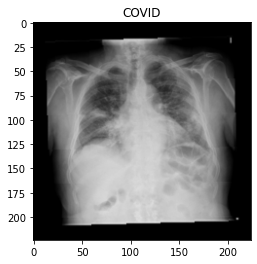

In [10]:
img,label = trainset[20]
print(trainset.class_to_idx)

class_name =["COVID","NORMAL","PNEUMONIA"]
show_image(img,class_name[label])

{'covid': 0, 'normal': 1, 'pneumonia': 2}


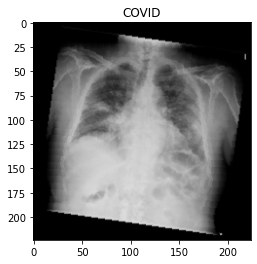

In [11]:
img,label = trainset[20]
print(trainset.class_to_idx)

class_name =["COVID","NORMAL","PNEUMONIA"]
show_image(img,class_name[label]) 

# randomly rotated

In [10]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [11]:
trainloader = DataLoader(trainset,batch_size=64,shuffle=True)
print("No. of batches in trainloader:{}".format(len(trainloader))) #Trainset Size:  5216 / batch_size: 16 = 326(No. of batches in trainloader) 
print("No. of Total examples:{}".format(len(trainloader.dataset)))

No. of batches in trainloader:281
No. of Total examples:17958


In [12]:
validationloader = DataLoader(validateset,batch_size=32,shuffle=True)
print("No. of batches in validationloader:{}".format(len(validationloader))) #validationset Size:  16 / batch_size: 16 = 1(No. of batches in validationloader) 
print("No. of Total examples:{}".format(len(validationloader.dataset)))

No. of batches in validationloader:108
No. of Total examples:3432


In [16]:
dataiter = iter(trainloader)
images,labels = dataiter.next()

out = make_grid(images,nrow=4)

show_grid(out,title = [class_name[x] for x in labels])

In [13]:
from torch import nn
import torch.nn.functional as F
import timm # PyTorch Image Models

model = timm.create_model(CFG.model_name,pretrained=True) #load pretrained model

In [16]:
model          

EfficientNet(
  (conv_stem): Conv2dSame(3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SiLU(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
        (bn1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
     

In [14]:
#let's update the pretarined model:
for param in model.parameters():
    param.requires_grad=True

#orginally, it was:
#(classifier): Linear(in_features=1792, out_features=1000, bias=True)


#we are updating it as a 2-class classifier:
model.classifier = nn.Sequential(
    nn.Linear(in_features=1792, out_features=625), #1792 is the orginal in_features
    nn.ReLU(), #ReLu to be the activation function
    nn.Dropout(p=0.3),
    nn.Linear(in_features=625, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=3), 
)

model

# after updatingnow it becomes:
#(classifier): Sequential(
#    (0): Linear(in_features=1792, out_features=625, bias=True)
#    (1): ReLU()
#    (2): Dropout(p=0.3, inplace=False)
#    (3): Linear(in_features=625, out_features=256, bias=True)
#    (4): ReLU()
#    (5): Linear(in_features=256, out_features=2, bias=True)
#  )

EfficientNet(
  (conv_stem): Conv2dSame(3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SiLU(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
        (bn1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
     

In [15]:
# from torchsummary import  summary
model.to(device) # move the model to GPU
# summary(model,input_size=(3,224,224))

EfficientNet(
  (conv_stem): Conv2dSame(3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SiLU(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
        (bn1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
     

In [71]:
class CovidTrainer():
    
    def __init__(self,criterion = None,optimizer = None,schedular = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor = 0.1,patience = 3)):
        
        self.criterion = criterion
        self.optimizer = optimizer
        self.schedular = schedular
    
    def train_batch_loop(self,model,trainloader):
        
        train_loss = 0.0
        train_acc = 0.0
        
        for images,labels in tqdm(trainloader): 
            
            # move the data to CPU
            images = images.to(device)
            labels = labels.to(device)
            
            logits = model(images)
            loss = self.criterion(logits,labels)
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            train_loss += loss.item()
            train_acc += accuracy(logits,labels)
            
        return train_loss / len(trainloader), train_acc / len(trainloader) 

    
    def valid_batch_loop(self,model,validloader):
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for images,labels in tqdm(validloader):
            
            # move the data to CPU
            images = images.to(device) 
            labels = labels.to(device)
            
            logits = model(images)
            loss = self.criterion(logits,labels)
            
            valid_loss += loss.item()
            valid_acc += accuracy(logits,labels)
            
        self.schedular.step(valid_acc / len(validloader))
            
        return valid_loss / len(validloader), valid_acc / len(validloader)
            
        
    def fit(self,model,trainloader,validloader,epochs):
        
        valid_min_loss = np.Inf 
        
        for i in range(epochs):
            
            model.train() # this turn on dropout
            avg_train_loss, avg_train_acc = self.train_batch_loop(model,trainloader) ###
            
            model.eval()  # this turns off the dropout lapyer and batch norm
            avg_valid_loss, avg_valid_acc = self.valid_batch_loop(model,validloader) ###
            
            if avg_valid_loss <= valid_min_loss :
                print("Valid_loss decreased {} --> {}".format(valid_min_loss,avg_valid_loss))
                torch.save(model.state_dict(),'ColabPneumoniaModel_scheduler.pt')
                valid_min_loss = avg_valid_loss

                
            print("Epoch : {} Train Loss : {:.6f} Train Acc : {:.6f}".format(i+1, avg_train_loss, avg_train_acc))
            print("Epoch : {} Valid Loss : {:.6f} Valid Acc : {:.6f}".format(i+1, avg_valid_loss, avg_valid_acc))

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = CFG.lr)

trainer = CovidTrainer(criterion,optimizer)
trainer.fit(model,trainloader,validationloader,epochs = CFG.epochs)

### Infernece

In [25]:
import pandas as pd
import seaborn as sns

def calc_confusion_matrix(model, loader, device, nb_classes):
    confusion_matrix = np.zeros((nb_classes, nb_classes))
    with torch.no_grad():
        for i, (inputs, classes) in tqdm(enumerate(loader)):
            inputs = inputs.to(device)
            classes = classes.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for t, p in zip(classes, preds.view(-1)):
                    confusion_matrix[t.long(), p.long()] += 1
    return confusion_matrix.astype(int)


def plot_confusion_matrix(confusion_matrix, validloader, path_save):
    plt.figure(figsize=(15,10))

    class_names = validationloader.dataset.classes
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    try:
        plt.savefig(path_save)
    except:
        pass


In [21]:
model.load_state_dict(torch.load('./effNet-kaggleModel.pt'))
model.eval()
confusion_matrix = calc_confusion_matrix(model, validationloader,'cuda',3)



0it [00:00, ?it/s]

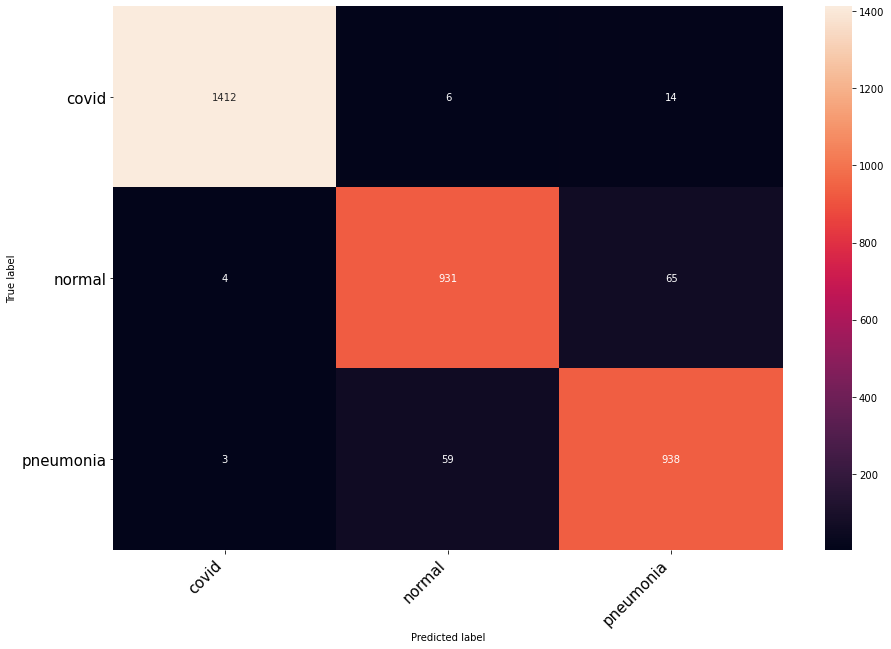

In [26]:
plot_confusion_matrix(confusion_matrix, validationloader, None)

In [27]:
validationloader.dataset.classes

['covid', 'normal', 'pneumonia']

### Test Dataset

In [41]:
import pandas as pd
import os
from torch.utils.data import Dataset
from PIL import Image
import time

class covid_dataset(Dataset):
    def __init__(self, image_loc, label_loc, transform):
        filenames = os.listdir(image_loc)
        self.full_filenames = [os.path.join(image_loc,f) for f in filenames]
        label_df = pd.read_csv(label_loc)
        label_df.set_index("case", inplace = True)
        
        self.labels = [label_df.loc[filename].values[0] for filename in filenames]
        
        self.transform = transform
        
    def __len__(self):
        return len(self.full_filenames)
    
    def __getitem__(self,idx):
        image = Image.open(self.full_filenames[idx])
        image = image.convert('RGB')
        image = self.transform(image)
        return image, self.labels[idx]

test_data = covid_dataset(image_loc = "/media/brats/DRIVE1/akansh/DeepXrays/Data/raw/Chest XR covid/test/",
                         label_loc = "/media/brats/DRIVE1/akansh/DeepXrays/Data/raw/submission.csv",
                         transform = validate_transform)

def deploy_model(model, dataset, device, num_classes = 3, sanity_check = False):
    len_data = len(dataset)
    y_out=torch.zeros(len_data,num_classes)
    y_gt=np.zeros((len_data),dtype="uint8")
    model=model.to(device)
    elapsed_times=[]
    with torch.no_grad():
        for i in tqdm(range(len_data)):
            x,y = dataset[i]
#             y_gt[i] = y
            start=time.time()
            y_out[i]=F.softmax(model(x.unsqueeze(0).to(device)),dim = 1)
            elapsed=time.time()-start
            elapsed_times.append(elapsed)
            if sanity_check is True:
                break
            inference_time=np.mean(elapsed_times)*1000
    print("average inference time per image on %s: %.2f ms "%(device,inference_time))
    return y_out.numpy(),y_gt
        

In [68]:
y_test_out,_=deploy_model(model,test_data, device,sanity_check=False)
y_test_pred=np.argmax(y_test_out,axis=1)
print(y_test_pred)
print(np.unique(y_test_pred, return_counts=True))

  0%|          | 0/1200 [00:00<?, ?it/s]

average inference time per image on cuda: 36.80 ms 


In [139]:
test_csv = pd.read_csv("/media/brats/DRIVE1/akansh/DeepXrays/Data/raw/submission.csv")

In [59]:
test_csv[' class'] = y_test_pred
test_csv.to_csv('second_sub_akansh.csv', index = False)

### Ensemble: Average SUM

In [22]:
eff_y_test_prob = np.load("./efficient-kaggle.npy")
denseNet_y_test_prob = np.load("./densenet.npy")

In [23]:
ensemble = np.sum(np.concatenate((np.expand_dims(eff_y_test_prob, axis=2),np.expand_dims(denseNet_y_test_prob, axis=2)),axis = 2),axis = 2)
y_pred_ensemble  = F.softmax(torch.from_numpy(ensemble), dim = 1).numpy()
y_pred_ensemble = np.argmax(y_pred_ensemble, axis=1)
print(np.unique(y_pred_ensemble, return_counts=True))

(array([0, 1, 2]), array([399, 421, 380]))


In [140]:
test_csv[' class'] = y_pred_ensemble
test_csv.to_csv('third_sub_akansh.csv', index = False)

### Look into Mis-classified Images by efficientNet

In [17]:
model.load_state_dict(torch.load('./effNet-kaggleModel.pt'))
model.eval()

EfficientNet(
  (conv_stem): Conv2dSame(3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SiLU(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
        (bn1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
     

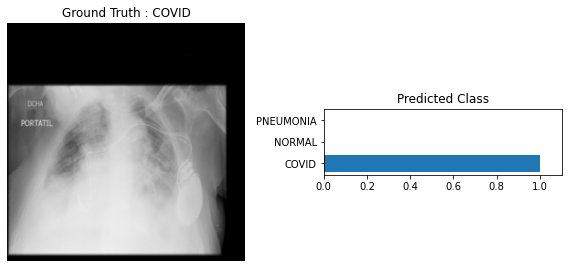

In [18]:
import torch.nn.functional as F

image,label = validateset[15]

ps = model(image.to(device).unsqueeze(0))
ps = F.softmax(ps,dim = 1)

view_classify(image,ps,label)

In [20]:
missclassified_index = []
for i, (image, labels) in tqdm(enumerate(validateset)):
    ps = model(image.to(device).unsqueeze(0))
    ps = F.softmax(ps,dim = 1)
    
    if labels != np.argmax(ps.cpu().detach().numpy()):
        missclassified_index.append(i)

        
    

0it [00:00, ?it/s]

In [21]:
100-(len(missclassified_index)/3432)*100

95.6002331002331

In [22]:
missclassified_index

[28,
 163,
 170,
 179,
 197,
 234,
 254,
 270,
 295,
 331,
 526,
 547,
 681,
 763,
 885,
 962,
 970,
 1189,
 1400,
 1403,
 1477,
 1508,
 1553,
 1555,
 1557,
 1564,
 1593,
 1611,
 1621,
 1640,
 1643,
 1673,
 1690,
 1691,
 1695,
 1712,
 1713,
 1721,
 1755,
 1772,
 1858,
 1865,
 1867,
 1878,
 1892,
 1897,
 1904,
 1910,
 1912,
 1915,
 1975,
 1990,
 1994,
 1995,
 2023,
 2030,
 2040,
 2041,
 2054,
 2061,
 2104,
 2113,
 2150,
 2153,
 2165,
 2199,
 2204,
 2229,
 2241,
 2242,
 2247,
 2250,
 2270,
 2288,
 2289,
 2292,
 2333,
 2337,
 2347,
 2351,
 2365,
 2367,
 2370,
 2381,
 2396,
 2397,
 2421,
 2427,
 2430,
 2434,
 2442,
 2445,
 2453,
 2472,
 2475,
 2488,
 2501,
 2508,
 2539,
 2574,
 2621,
 2648,
 2689,
 2702,
 2711,
 2722,
 2735,
 2747,
 2754,
 2757,
 2780,
 2783,
 2784,
 2802,
 2804,
 2836,
 2888,
 2982,
 2988,
 3004,
 3005,
 3022,
 3026,
 3045,
 3057,
 3064,
 3082,
 3108,
 3157,
 3184,
 3193,
 3197,
 3208,
 3220,
 3223,
 3228,
 3247,
 3251,
 3256,
 3262,
 3270,
 3272,
 3279,
 3332,
 3354,
 33

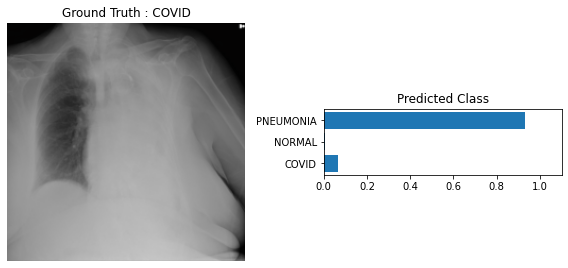

In [23]:
import torch.nn.functional as F

image,label = validateset[missclassified_index[0]]

ps = model(image.to(device).unsqueeze(0))
ps = F.softmax(ps,dim = 1)

view_classify(image,ps,label)

In [24]:
missclassified_index

[28,
 163,
 170,
 179,
 197,
 234,
 254,
 270,
 295,
 331,
 526,
 547,
 681,
 763,
 885,
 962,
 970,
 1189,
 1400,
 1403,
 1477,
 1508,
 1553,
 1555,
 1557,
 1564,
 1593,
 1611,
 1621,
 1640,
 1643,
 1673,
 1690,
 1691,
 1695,
 1712,
 1713,
 1721,
 1755,
 1772,
 1858,
 1865,
 1867,
 1878,
 1892,
 1897,
 1904,
 1910,
 1912,
 1915,
 1975,
 1990,
 1994,
 1995,
 2023,
 2030,
 2040,
 2041,
 2054,
 2061,
 2104,
 2113,
 2150,
 2153,
 2165,
 2199,
 2204,
 2229,
 2241,
 2242,
 2247,
 2250,
 2270,
 2288,
 2289,
 2292,
 2333,
 2337,
 2347,
 2351,
 2365,
 2367,
 2370,
 2381,
 2396,
 2397,
 2421,
 2427,
 2430,
 2434,
 2442,
 2445,
 2453,
 2472,
 2475,
 2488,
 2501,
 2508,
 2539,
 2574,
 2621,
 2648,
 2689,
 2702,
 2711,
 2722,
 2735,
 2747,
 2754,
 2757,
 2780,
 2783,
 2784,
 2802,
 2804,
 2836,
 2888,
 2982,
 2988,
 3004,
 3005,
 3022,
 3026,
 3045,
 3057,
 3064,
 3082,
 3108,
 3157,
 3184,
 3193,
 3197,
 3208,
 3220,
 3223,
 3228,
 3247,
 3251,
 3256,
 3262,
 3270,
 3272,
 3279,
 3332,
 3354,
 33